In [345]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

# Set option to display all columns
pd.set_option('display.max_columns', None)

# Ignore warnings
warnings.filterwarnings('ignore')

In [346]:
df = pd.read_csv('model_with_account.csv')

In [347]:
df.shape

(223918, 76)

In [348]:
df.head()

,Unnamed: 0,uid,total_loan_amount,avg_loan_amount,max_loan_amount,total_amount_overdue,avg_amount_overdue,max_amount_overdue,proportion_overdue,ongoing_loan_amount,closed_loan_amount,ongoing_loan_count,closed_loan_count,loan_status_ratio,avg_loan_duration,max_loan_duration,min_loan_duration,loan_type_diversity,max_days_overdue,min_days_overdue,avg_days_overdue,count_overdue_months,most_recent_payment_status,consumer_credit_count,credit_card_count,other_loans_count,enquiry_count,avg_enquiry_amt,total_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt,min_enquiry_amt,max_enquiry_amt,days_since_first_enquiry,avg_days_between_enquiries,enquiry_count_10,enquiry_count_30,enquiry_type_Another type of loan_count,enquiry_type_Car loan_count,enquiry_type_Cash loan (non-earmarked)_count,enquiry_type_Cash loans_count,enquiry_type_Consumer credit_count,enquiry_type_Credit card_count,enquiry_type_Interbank credit_count,enquiry_type_Loan for business development_count,enquiry_type_Loan for purchase of shares (margin lending)_count,enquiry_type_Loan for the purchase of equipment_count,enquiry_type_Loan for working capital replenishment_count,enquiry_type_Microloan_count,enquiry_type_Mobile operator loan_count,enquiry_type_Mortgage_count,enquiry_type_Real estate loan_count,enquiry_type_Revolving loans_count,enquiry_type_Unknown type of loan_count,NAME_CONTRACT_TYPE,TARGET,enquiry_year,enquiry_month,enquiry_type_hot_Another type of loan,enquiry_type_hot_Car loan,enquiry_type_hot_Cash loan (non-earmarked),enquiry_type_hot_Cash loans,enquiry_type_hot_Consumer credit,enquiry_type_hot_Credit card,enquiry_type_hot_Interbank credit,enquiry_type_hot_Loan for business development,enquiry_type_hot_Loan for purchase of shares (margin lending),enquiry_type_hot_Loan for the purchase of equipment,enquiry_type_hot_Loan for working capital replenishment,enquiry_type_hot_Microloan,enquiry_type_hot_Mobile operator loan,enquiry_type_hot_Mortgage,enquiry_type_hot_Real estate loan,enquiry_type_hot_Revolving loans,enquiry_type_hot_Unknown type of loan
0,1,AAA09044550,277245.000,138622.500,272745.000,0.0,0.0,0.0,0.0,0.000,277245.0,0.0,2.0,0.0,511.00,518.0,504.0,1.0,44.0,0.0,2.106618,3.0,0.0,2.0,0.0,0.0,26,102269.230769,2659000,2020-12-29,18,197000,5000,197000,1169,-4,1,3,3,3,1,7,1,1,2,0,0,1,0,2,1,1,1,1,1,0,0,2020,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,AAA10545297,80996.445,80996.445,80996.445,0.0,0.0,0.0,0.0,80996.445,0.0,1.0,0.0,1.0,186.00,186.0,186.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,14,94071.428571,1317000,2020-10-29,32,192000,5000,192000,846,-23,1,1,1,0,2,2,2,2,1,0,1,0,0,0,0,0,0,2,1,0,0,2020,10,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,AAA14112888,43771.500,43771.500,43771.500,0.0,0.0,0.0,0.0,0.000,43771.5,0.0,1.0,0.0,92.00,92.0,92.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,15,97666.666667,1465000,2020-07-05,4,185000,17000,185000,1179,0,3,3,1,0,1,1,2,0,1,0,2,2,2,0,2,0,0,0,1,0,0,2020,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,AAA20326915,591597.000,73949.625,235800.000,0.0,0.0,0.0,0.0,102100.500,489496.5,3.0,5.0,0.6,577.75,2305.0,31.0,2.0,917.0,0.0,23.810855,31.0,0.0,5.0,3.0,0.0,1,66000.000000,66000,2020-08-14,0,66000,66000,66000,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2020,8,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5,AAA31604840,1591960.500,318392.100,687150.000,0.0,0.0,0.0,0.0,1245150.000,346810.5,3.0,2.0,1.5,483.80,1302.0,83.0,2.0,0.0,0.0,0.000000,0.0,0.0,4.0,1.0,0.0,19,96105.263158,1826000,2020-11-27,4,195000,10000,195000,825,19,2,2,1,0,1,1,2,0,1,3,2,2,0,0,0,0,2,0,4,0,0,2020,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [349]:
# Get columns with missing values and their counts
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

avg_loan_amount    1
max_loan_amount    1
dtype: int64


In [350]:
df = df.dropna()

In [351]:
# Define columns to exclude
exclude_cols = ['Unnamed: 0', 'uid', 'recent_enquiry_date']

# Create a list of features excluding the columns to be excluded
features = [col for col in df.columns if col not in exclude_cols and col != 'TARGET']

# Prepare the feature matrix X and target vector y
X = df[features]
y = df['TARGET']

In [352]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=49)

In [353]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='auc', random_state=42)
}

# Train, predict, and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    print(f'{name} ROC AUC: {roc_auc:.4f}')

Logistic Regression ROC AUC: 0.6015
Random Forest ROC AUC: 0.6128
XGBoost ROC AUC: 0.6502


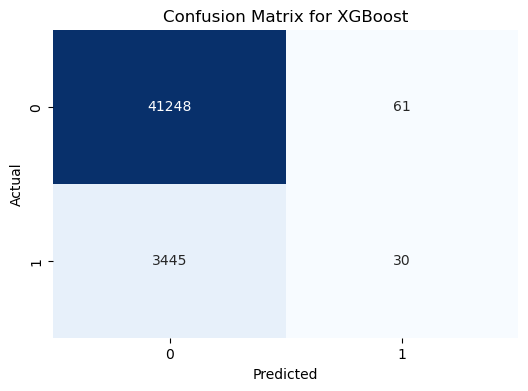

In [354]:
# Make predictions using the XGBoost model
xgb_model = models['XGBoost']
y_pred_xgb = xgb_model.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()

In [355]:
# feature selection

In [356]:
sel = df.drop(columns=['uid', 'recent_enquiry_date', 'Unnamed: 0'])

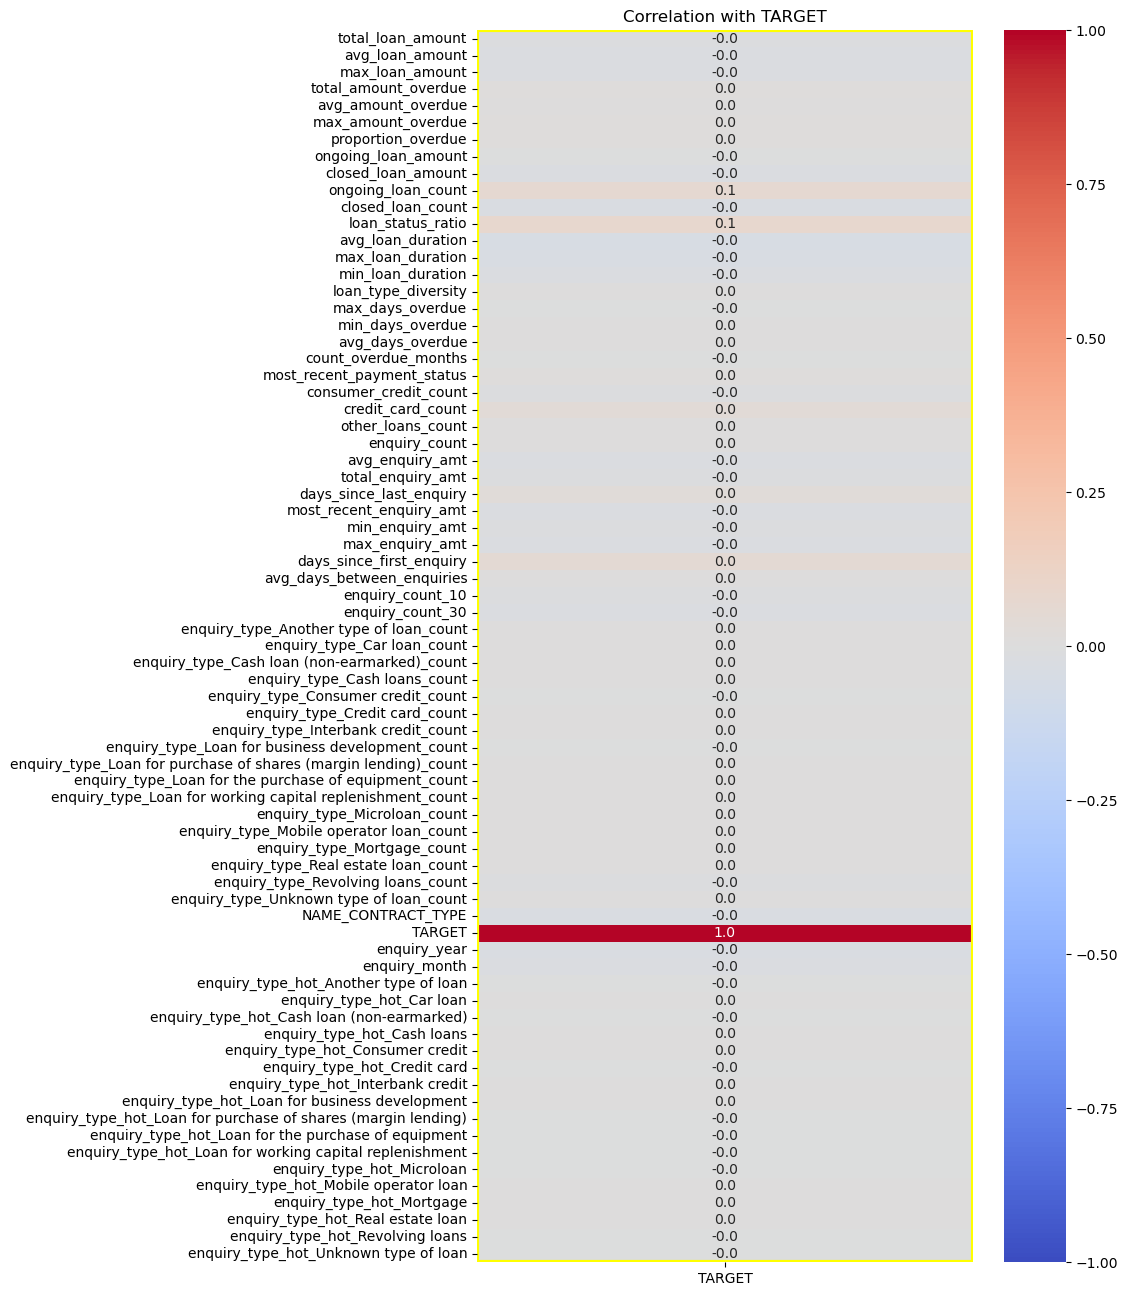

In [357]:
corr_matrix = sel.corr()

# Filter the correlation matrix to show only correlations with TARGET
target_corr = corr_matrix[['TARGET']]

# Plotting the heatmap
plt.figure(figsize=(8, 16))
sns.heatmap(target_corr, annot=True, fmt=".1f", cmap='coolwarm', vmin=-1, vmax=1, center=0)

# Highlight the TARGET row and column
plt.gca().add_patch(plt.Rectangle((0, 0), len(target_corr.columns), len(target_corr.index), fill=False, edgecolor='yellow', lw=3))

plt.title('Correlation with TARGET')
plt.show()

In [358]:
# Separate the features and target
X = sel.drop(columns=['TARGET'])
y = sel['TARGET']

# Calculate the mutual information for each feature with the target
info_gain = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame to hold the results
info_gain_df = pd.DataFrame({'Feature': X.columns, 'Info_Gain': info_gain})

# Sort the DataFrame by Information Gain in descending order
info_gain_df = info_gain_df.sort_values(by='Info_Gain', ascending=False)

# Display the results
print(info_gain_df)

                                              Feature  Info_Gain
53                                       enquiry_year   0.042247
33                                   enquiry_count_10   0.037366
34                                   enquiry_count_30   0.019986
15                                loan_type_diversity   0.017196
9                                  ongoing_loan_count   0.009662
..                                                ...        ...
63  enquiry_type_hot_Loan for purchase of shares (...   0.000000
17                                   min_days_overdue   0.000000
20                         most_recent_payment_status   0.000000
16                                   max_days_overdue   0.000000
71              enquiry_type_hot_Unknown type of loan   0.000000

[72 rows x 2 columns]


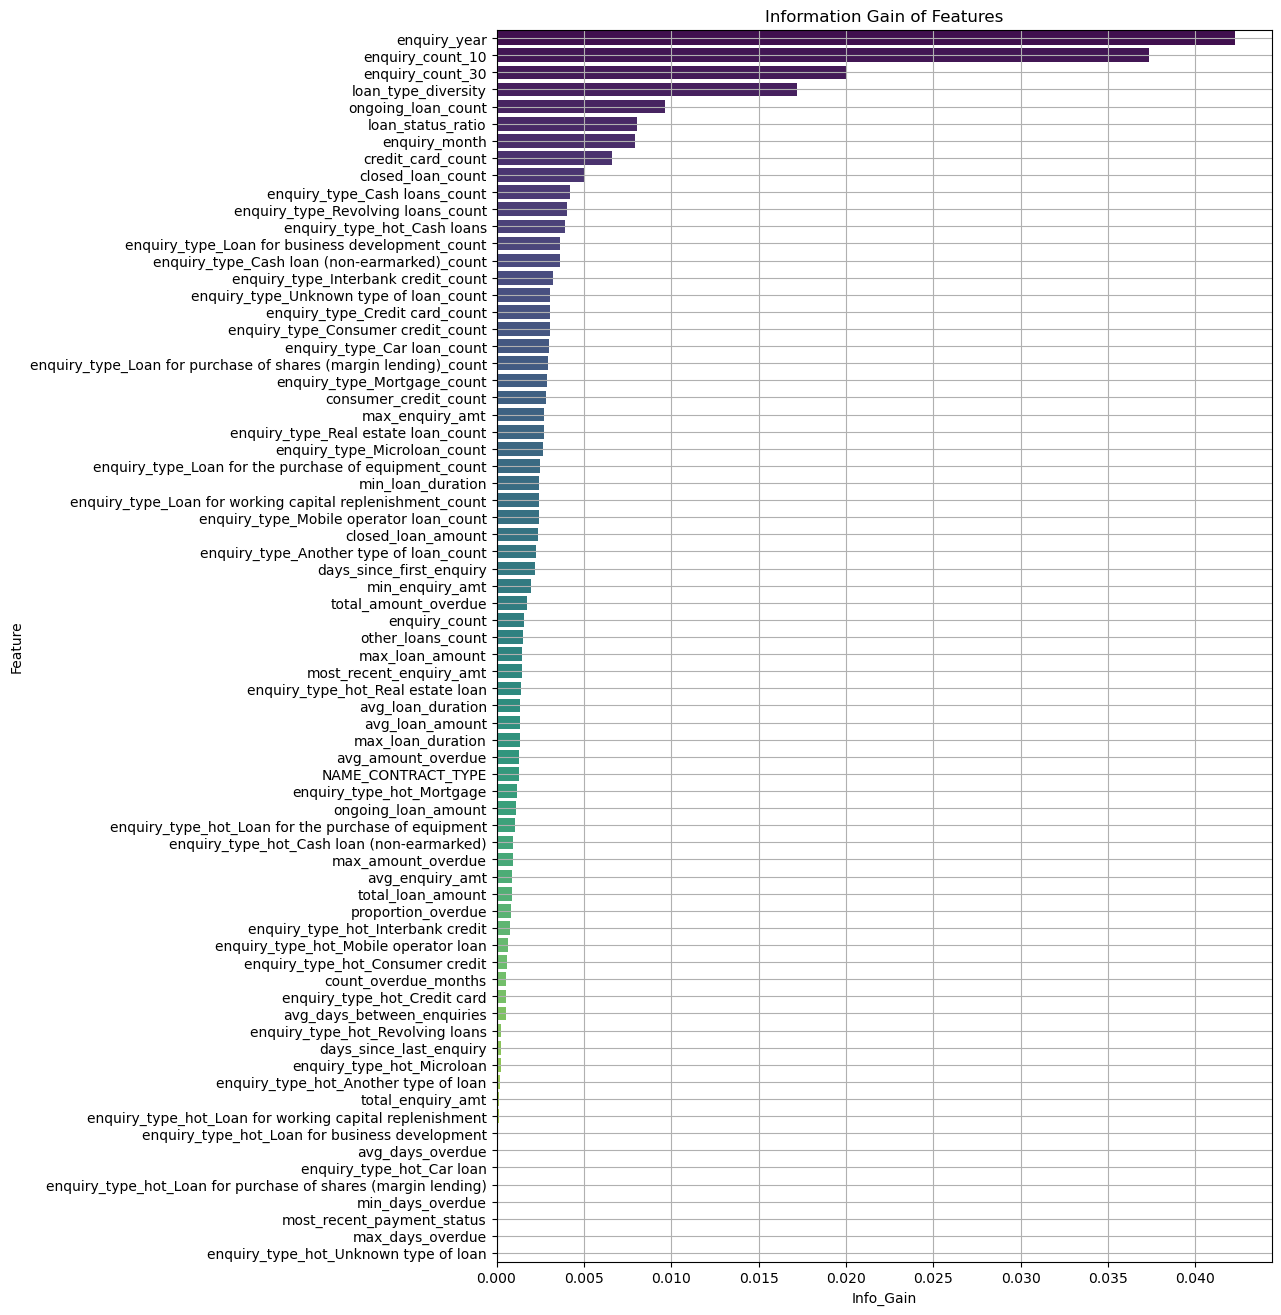

In [359]:
# Plot the Information Gain for each feature
plt.figure(figsize=(10, 16))
sns.barplot(x='Info_Gain', y='Feature', data=info_gain_df, palette='viridis')
plt.title('Information Gain of Features')
plt.grid(True)
plt.show()

In [360]:
# Calculate how many features represent the top half
top_half_count = len(info_gain_df) // 2

# Select the top half features
top_features = info_gain_df.iloc[:top_half_count]['Feature'].tolist()

# Create a new DataFrame with only the top features
X_top = X[top_features]

print(f'Selected top {top_half_count} features based on Information Gain:')
print(top_features)

Selected top 36 features based on Information Gain:
['enquiry_year', 'enquiry_count_10', 'enquiry_count_30', 'loan_type_diversity', 'ongoing_loan_count', 'loan_status_ratio', 'enquiry_month', 'credit_card_count', 'closed_loan_count', 'enquiry_type_Cash loans_count', 'enquiry_type_Revolving loans_count', 'enquiry_type_hot_Cash loans', 'enquiry_type_Loan for business development_count', 'enquiry_type_Cash loan (non-earmarked)_count', 'enquiry_type_Interbank credit_count', 'enquiry_type_Unknown type of loan_count', 'enquiry_type_Credit card_count', 'enquiry_type_Consumer credit_count', 'enquiry_type_Car loan_count', 'enquiry_type_Loan for purchase of shares (margin lending)_count', 'enquiry_type_Mortgage_count', 'consumer_credit_count', 'max_enquiry_amt', 'enquiry_type_Real estate loan_count', 'enquiry_type_Microloan_count', 'enquiry_type_Loan for the purchase of equipment_count', 'min_loan_duration', 'enquiry_type_Loan for working capital replenishment_count', 'enquiry_type_Mobile operat

In [361]:
# # Convert recent_enquiry_date to datetime if not already
# df['recent_enquiry_date'] = pd.to_datetime(df['recent_enquiry_date'])

# # Create the month_index feature by extracting the month and year, then converting to an index
# df['month_index'] = (df['recent_enquiry_date'].dt.year - df['recent_enquiry_date'].dt.year.min()) * 12 + df['recent_enquiry_date'].dt.month

# # Add month_index to your top features DataFrame
# X_top['month_index'] = df['month_index']

# # Display the updated DataFrame
# X_top.head()

In [362]:
# modelling

In [363]:
# top_features.append('month_index')
top_features.append('days_since_last_enquiry')

# Prepare the feature matrix X and target vector y using only the top features
X_top = df[top_features]
y = df['TARGET']

In [364]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_top, y, test_size=0.2, random_state=42)

In [365]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='auc', random_state=42)
}

# Train, predict, and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on validation and training sets
    y_pred_prob_val = model.predict_proba(X_val)[:, 1]
    y_pred_prob_train = model.predict_proba(X_train)[:, 1]
    
    # Calculate ROC AUC scores
    roc_auc_val = roc_auc_score(y_val, y_pred_prob_val)
    roc_auc_train = roc_auc_score(y_train, y_pred_prob_train)
    
    print(f'{name} ROC AUC (Validation): {roc_auc_val:.4f}')
    print(f'{name} ROC AUC (Train): {roc_auc_train:.4f}')

Logistic Regression ROC AUC (Validation): 0.6179
Logistic Regression ROC AUC (Train): 0.6172
Random Forest ROC AUC (Validation): 0.6172
Random Forest ROC AUC (Train): 1.0000
XGBoost ROC AUC (Validation): 0.6441
XGBoost ROC AUC (Train): 0.7869


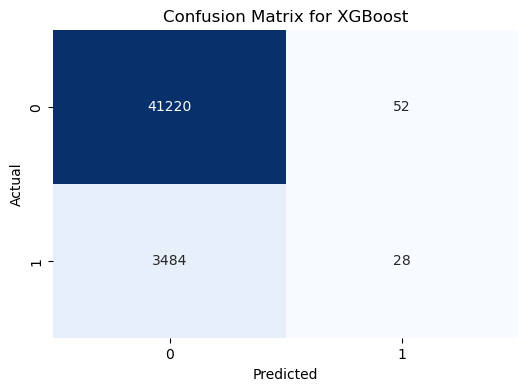

In [366]:
# Make predictions using the XGBoost model
xgb_model = models['XGBoost']
y_pred_xgb = xgb_model.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()

In [212]:
df.sample(5)

,Unnamed: 0,uid,total_loan_amount,avg_loan_amount,max_loan_amount,total_amount_overdue,avg_amount_overdue,max_amount_overdue,proportion_overdue,ongoing_loan_amount,closed_loan_amount,ongoing_loan_count,closed_loan_count,loan_status_ratio,avg_loan_duration,max_loan_duration,min_loan_duration,loan_type_diversity,max_days_overdue,min_days_overdue,avg_days_overdue,count_overdue_months,most_recent_payment_status,consumer_credit_count,credit_card_count,other_loans_count,enquiry_count,avg_enquiry_amt,total_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt,min_enquiry_amt,max_enquiry_amt,days_since_first_enquiry,avg_days_between_enquiries,enquiry_count_10,enquiry_count_30,enquiry_type_Another type of loan_count,enquiry_type_Car loan_count,enquiry_type_Cash loan (non-earmarked)_count,enquiry_type_Cash loans_count,enquiry_type_Consumer credit_count,enquiry_type_Credit card_count,enquiry_type_Interbank credit_count,enquiry_type_Loan for business development_count,enquiry_type_Loan for purchase of shares (margin lending)_count,enquiry_type_Loan for the purchase of equipment_count,enquiry_type_Loan for working capital replenishment_count,enquiry_type_Microloan_count,enquiry_type_Mobile operator loan_count,enquiry_type_Mortgage_count,enquiry_type_Real estate loan_count,enquiry_type_Revolving loans_count,enquiry_type_Unknown type of loan_count,NAME_CONTRACT_TYPE,TARGET,enquiry_year,enquiry_month,enquiry_type_hot_Another type of loan,enquiry_type_hot_Car loan,enquiry_type_hot_Cash loan (non-earmarked),enquiry_type_hot_Cash loans,enquiry_type_hot_Consumer credit,enquiry_type_hot_Credit card,enquiry_type_hot_Interbank credit,enquiry_type_hot_Loan for business development,enquiry_type_hot_Loan for purchase of shares (margin lending),enquiry_type_hot_Loan for the purchase of equipment,enquiry_type_hot_Loan for working capital replenishment,enquiry_type_hot_Microloan,enquiry_type_hot_Mobile operator loan,enquiry_type_hot_Mortgage,enquiry_type_hot_Real estate loan,enquiry_type_hot_Revolving loans,enquiry_type_hot_Unknown type of loan,month_index
181710,212039,VBW08274813,36295834.50,6049305.75,22500000.00,0.0,0.0,0.0,0.0,26471250.00,9824584.5,3.0,3.0,1.000000,1303.833333,2618.0,371.0,4.0,0.0,0.0,0.000000,0.0,0.0,2.0,1.0,3.0,4,94750.000000,379000,2020-11-28,3,137000,66000,137000,48,-6,2,3,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2020,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59
98630,115189,LMG07184238,4518000.00,1506000.00,1791000.00,0.0,0.0,0.0,0.0,4518000.00,0.0,3.0,0.0,3.000000,805.000000,1471.0,465.0,3.0,97.0,0.0,4.622222,4.0,0.0,1.0,1.0,1.0,4,66750.000000,267000,2020-10-10,14,121000,34000,121000,132,-36,1,3,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,2020,10,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,58
11694,13658,BJX16076133,4563153.00,304210.20,1125000.00,0.0,0.0,0.0,0.0,1178437.50,3384715.5,4.0,11.0,0.363636,406.133333,1793.0,27.0,2.0,105.0,0.0,1.266667,6.0,0.0,11.0,4.0,0.0,8,86625.000000,693000,2020-11-19,67,190000,7000,190000,844,51,1,1,1,0,0,0,1,0,0,0,1,0,1,2,0,0,1,0,1,0,0,2020,11,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,59
178912,208738,UTP60322498,675000.00,337500.00,495000.00,0.0,0.0,0.0,0.0,0.00,675000.0,0.0,2.0,0.000000,966.000000,1562.0,370.0,1.0,0.0,0.0,0.000000,0.0,0.0,2.0,0.0,0.0,2,113500.000000,227000,2020-08-30,136,119000,108000,119000,136,136,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2020,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,56
128145,149627,OWO18802926,124580.07,124580.07,124580.07,0.0,0.0,0.0,0.0,124580.07,0.0,1.0,0.0,1.000000,38.000000,38.0,38.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,7,245456.571429,1718196,2020-12-31,119,467250,37927,467250,516,-36,1,1,1,1,0,0,1,1,0,0,2,1,0,0,0,0,0,0,0,1,0,2020,12,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,60


In [213]:
df.TARGET.value_counts()

TARGET
0    206660
1     17257
Name: count, dtype: int64

In [214]:
# addressing class imbalance

In [218]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
model.fit(X_resampled, y_resampled)

# Evaluate model
y_pred_prob = model.predict_proba(X_val)[:, 1]  # Get the probabilities for the positive class
print(f'ROC AUC Score: {roc_auc_score(y_val, y_pred_prob):.4f}')

ROC AUC Score: 0.6206


In [222]:
y_resampled.value_counts()

TARGET
0    165388
1    120603
Name: count, dtype: int64

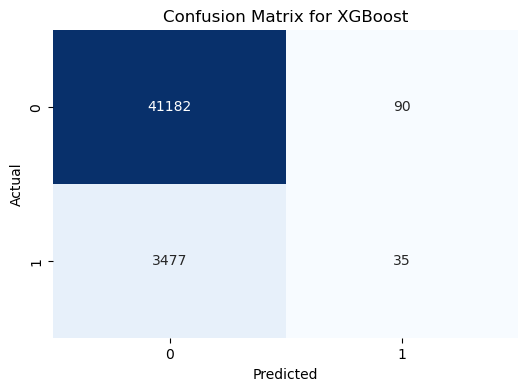

In [220]:
# Make predictions using the XGBoost model
xgb_model = model
y_pred_xgb = xgb_model.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()

In [221]:
# Define SMOTE and ENN
smote = SMOTE(sampling_strategy='minority', random_state=42)
enn = EditedNearestNeighbours()
pipeline = Pipeline(steps=[('o', smote), ('u', enn)])

# Apply SMOTE + ENN to the training data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
model.fit(X_resampled, y_resampled)

# Evaluate model
y_pred_prob = model.predict_proba(X_val)[:, 1]  # Get the probabilities for the positive class
print(f'ROC AUC Score: {roc_auc_score(y_val, y_pred_prob):.4f}')

ROC AUC Score: 0.6203


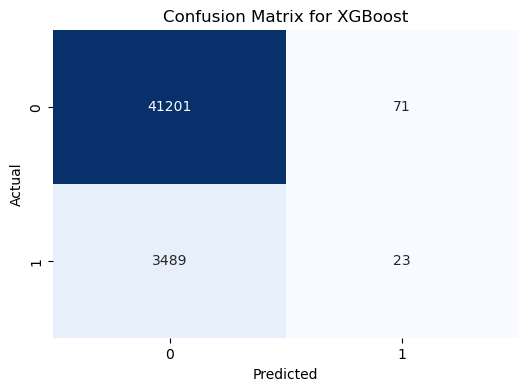

In [223]:
# Make predictions using the XGBoost model
xgb_model = model
y_pred_xgb = xgb_model.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()

<Figure size 800x1200 with 0 Axes>

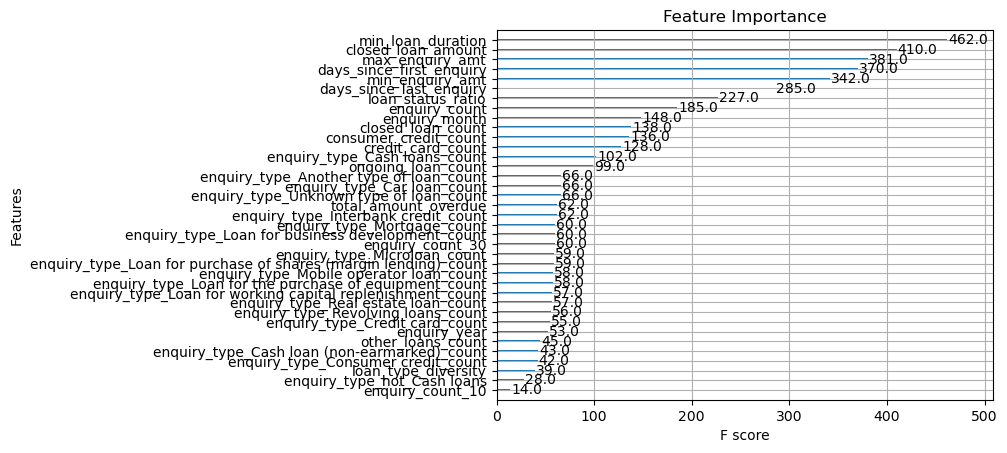

In [367]:
# Plot feature importance
plt.figure(figsize=(8, 12))
xgb.plot_importance(xgb_model, importance_type='weight', title='Feature Importance')
plt.show()

In [164]:
# new features: enquiry count in the last 10 days, 30 days, 60 days

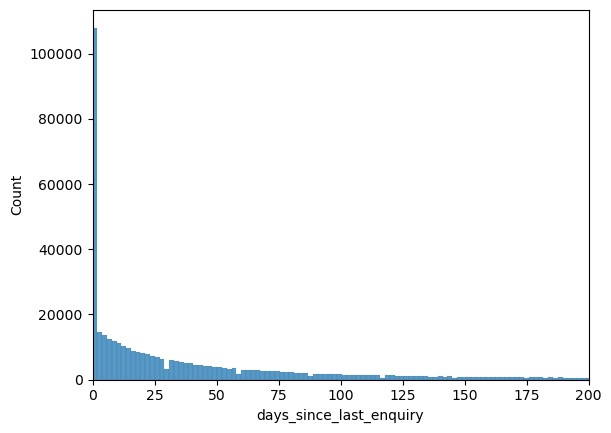

In [165]:
# Create the histogram plot
sns.histplot(df['days_since_last_enquiry'])

# Set the x-axis limit
plt.xlim(0, 200)
plt.show()

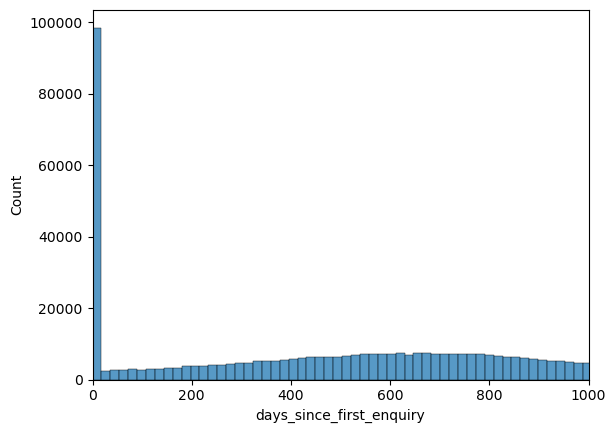

In [166]:
# Create the histogram plot
sns.histplot(df['days_since_first_enquiry'])

# Set the x-axis limit
plt.xlim(0, 1000)
plt.show()

In [167]:
df.sample(5)

,Unnamed: 0,uid,total_loan_amount,avg_loan_amount,max_loan_amount,total_amount_overdue,avg_amount_overdue,max_amount_overdue,proportion_overdue,ongoing_loan_amount,closed_loan_amount,ongoing_loan_count,closed_loan_count,loan_status_ratio,avg_loan_duration,max_loan_duration,min_loan_duration,loan_type_diversity,max_days_overdue,min_days_overdue,avg_days_overdue,count_overdue_months,most_recent_payment_status,consumer_credit_count,credit_card_count,other_loans_count,enquiry_count,avg_enquiry_amt,total_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt,min_enquiry_amt,max_enquiry_amt,days_since_first_enquiry,avg_days_between_enquiries,enquiry_date,enquiry_type_Another type of loan_count,enquiry_type_Car loan_count,enquiry_type_Cash loan (non-earmarked)_count,enquiry_type_Cash loans_count,enquiry_type_Consumer credit_count,enquiry_type_Credit card_count,enquiry_type_Interbank credit_count,enquiry_type_Loan for business development_count,enquiry_type_Loan for purchase of shares (margin lending)_count,enquiry_type_Loan for the purchase of equipment_count,enquiry_type_Loan for working capital replenishment_count,enquiry_type_Microloan_count,enquiry_type_Mobile operator loan_count,enquiry_type_Mortgage_count,enquiry_type_Real estate loan_count,enquiry_type_Revolving loans_count,enquiry_type_Unknown type of loan_count,NAME_CONTRACT_TYPE,TARGET,enquiry_year,enquiry_month,enquiry_type_hot_Another type of loan,enquiry_type_hot_Car loan,enquiry_type_hot_Cash loan (non-earmarked),enquiry_type_hot_Cash loans,enquiry_type_hot_Consumer credit,enquiry_type_hot_Credit card,enquiry_type_hot_Interbank credit,enquiry_type_hot_Loan for business development,enquiry_type_hot_Loan for purchase of shares (margin lending),enquiry_type_hot_Loan for the purchase of equipment,enquiry_type_hot_Loan for working capital replenishment,enquiry_type_hot_Microloan,enquiry_type_hot_Mobile operator loan,enquiry_type_hot_Mortgage,enquiry_type_hot_Real estate loan,enquiry_type_hot_Revolving loans,enquiry_type_hot_Unknown type of loan,month_index
437782,511030,ZKR22552250,4410351.000,4.900390e+05,1800000.0,0.0,0.0,0.0,0.0,2549106.0,1861245.000,4.0,5.0,0.800000,306.888889,690.0,85.0,1.0,6.0,0.0,0.111111,1.0,0.0,9.0,0.0,0.0,12,114916.666667,1379000,2020-12-09,3,197000,8000,197000,808,-74,3,0,1,2,1,2,0,1,1,0,0,2,1,0,0,0,0,1,0,0,2020,12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,60
366700,427846,VGT74888801,525073.095,1.050146e+05,337500.0,0.0,0.0,0.0,0.0,337500.0,187573.095,1.0,4.0,0.250000,494.600000,1359.0,63.0,2.0,0.0,0.0,0.000000,0.0,0.0,4.0,1.0,0.0,5,91200.000000,456000,2020-11-21,59,146000,13000,146000,961,-142,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2020,11,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,59
293370,342418,RAD36419520,2832885.000,4.721475e+05,1125000.0,0.0,0.0,0.0,0.0,715500.0,2117385.000,2.0,4.0,0.500000,820.500000,1707.0,112.0,2.0,302.0,0.0,4.976190,11.0,0.0,4.0,2.0,0.0,1,63000.000000,63000,2019-07-09,0,63000,63000,63000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2019,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,43
316334,369142,SJB58456617,2344715.550,2.131560e+05,900000.0,0.0,0.0,0.0,0.0,1350000.0,994715.550,2.0,9.0,0.222222,357.363636,1778.0,33.0,2.0,12.0,0.0,0.272727,1.0,0.0,10.0,1.0,0.0,1,31000.000000,31000,2019-05-26,0,31000,31000,31000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,41
134217,156711,HUU22045087,8737065.000,2.912355e+06,6750000.0,0.0,0.0,0.0,0.0,6750000.0,1987065.000,1.0,2.0,0.500000,537.333333,1102.0,146.0,3.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,2.0,2,29500.000000,59000,2020-06-20,111,49000,10000,49000,111,-111,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2020,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54


In [254]:
# Shave off some features from the bottom

In [262]:
# Let's assume you identified the bottom 4 features from the plot
bottom_features = ['enquiry_year', 'enquiry_type_hot_Cash loans', 'enquiry_count_10']

# Remove the bottom 4 features from the top_features list
top_features = [feature for feature in top_features if feature not in bottom_features]

In [263]:
# cross validation and hyperparameter tuning (xg boost, one with class weights)

In [368]:
# Prepare the feature matrix X and target vector y using only the top features
X_top = df[top_features]
y = df['TARGET']

In [369]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_top, y, test_size=0.2, random_state=42)

In [371]:
from sklearn.model_selection import cross_val_score, GridSearchCV

xgb_model = xgb.XGBClassifier(eval_metric='auc', random_state=42)

# Define hyperparameters to tune
param_grid = {
  'n_estimators': [150],
  'max_depth': [10],
  'learning_rate': [0.1, 0.3],
  'gamma': [0, 0.2],
  'reg_alpha': [1,2],
  'reg_lambda': [2],
  'scale_pos_weight': [1, 2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'reg_alpha': 2, 'reg_lambda': 2, 'scale_pos_weight': 1}


In [372]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Fit the best model on the entire training set (optional if you want to use the model directly from GridSearchCV)
best_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_val, y_prob)
print(f'Validation ROC AUC: {roc_auc:.4f}')

Validation ROC AUC: 0.6410


In [373]:
# run a simple xgboost model for df2

In [374]:
df = pd.read_csv('model_wo_account.csv')

In [375]:
df = df.dropna(axis=1, how='any')

In [376]:
# # Convert recent_enquiry_date to datetime if not already
# df['recent_enquiry_date'] = pd.to_datetime(df['recent_enquiry_date'])

# # Create the month_index feature by extracting the month and year, then converting to an index
# df['month_index'] = (df['recent_enquiry_date'].dt.year - df['recent_enquiry_date'].dt.year.min()) * 12 + df['recent_enquiry_date'].dt.month

In [377]:
# Define columns to exclude
exclude_cols = ['Unnamed: 0', 'uid', 'recent_enquiry_date']

# Create a list of features excluding the columns to be excluded
features = [col for col in df.columns if col not in exclude_cols and col != 'TARGET']

# Prepare the feature matrix X and target vector y
X = df[features]
y = df['TARGET']

In [378]:
features

['enquiry_count',
 'avg_enquiry_amt',
 'total_enquiry_amt',
 'days_since_last_enquiry',
 'most_recent_enquiry_amt',
 'min_enquiry_amt',
 'max_enquiry_amt',
 'days_since_first_enquiry',
 'avg_days_between_enquiries',
 'enquiry_count_10',
 'enquiry_count_30',
 'enquiry_type_Another type of loan_count',
 'enquiry_type_Car loan_count',
 'enquiry_type_Cash loan (non-earmarked)_count',
 'enquiry_type_Cash loans_count',
 'enquiry_type_Consumer credit_count',
 'enquiry_type_Credit card_count',
 'enquiry_type_Interbank credit_count',
 'enquiry_type_Loan for business development_count',
 'enquiry_type_Loan for purchase of shares (margin lending)_count',
 'enquiry_type_Loan for the purchase of equipment_count',
 'enquiry_type_Loan for working capital replenishment_count',
 'enquiry_type_Microloan_count',
 'enquiry_type_Mobile operator loan_count',
 'enquiry_type_Mortgage_count',
 'enquiry_type_Real estate loan_count',
 'enquiry_type_Revolving loans_count',
 'enquiry_type_Unknown type of loan_coun

In [379]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=49)

In [380]:
# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
model.fit(X_train, y_train)

# Evaluate model
y_pred_prob = model.predict_proba(X_val)[:, 1]  # Get the probabilities for the positive class
print(f'ROC AUC Score: {roc_auc_score(y_val, y_pred_prob):.4f}')
y_pred_prob1 = model.predict_proba(X_train)[:, 1]  # Get the probabilities for the positive class
print(f'ROC AUC Score: {roc_auc_score(y_train, y_pred_prob1):.4f}')

ROC AUC Score: 0.5538
ROC AUC Score: 0.9341


In [381]:
# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred_prob = model.predict_proba(X_val)[:, 1]  # Get the probabilities for the positive class
print(f'ROC AUC Score: {roc_auc_score(y_val, y_pred_prob):.4f}')
y_pred_prob1 = model.predict_proba(X_train)[:, 1]  # Get the probabilities for the positive class
print(f'ROC AUC Score: {roc_auc_score(y_train, y_pred_prob1):.4f}')

ROC AUC Score: 0.5612
ROC AUC Score: 1.0000


In [382]:
# Train XGBoost model with regularization
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    alpha=1,        # L1 regularization term on weights
    lambda_=5,      # L2 regularization term on weights
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate model on validation set
y_pred_prob_val = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class
print(f'Validation ROC AUC Score: {roc_auc_score(y_val, y_pred_prob_val):.4f}')

# Evaluate model on training set
y_pred_prob_train = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class
print(f'Training ROC AUC Score: {roc_auc_score(y_train, y_pred_prob_train):.4f}')

Validation ROC AUC Score: 0.5671
Training ROC AUC Score: 0.9414


<Figure size 800x1200 with 0 Axes>

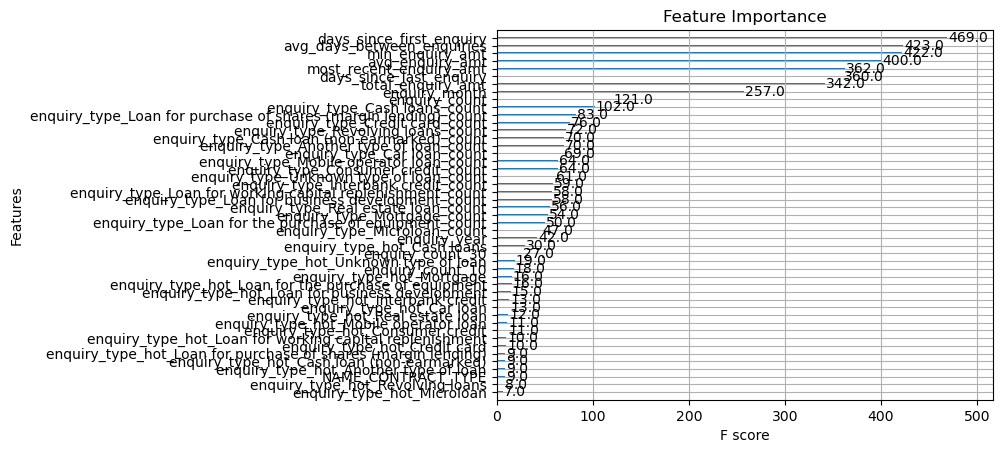

In [383]:
# Plot feature importance
plt.figure(figsize=(8, 12))
xgb.plot_importance(model, importance_type='weight', title='Feature Importance')
plt.show()

In [384]:
# combine the predictions

In [385]:
# test data preprocessing

In [386]:
# test data
test_flag = pd.read_csv('data/test/test_flag.csv')

# train accounts data
f = open('data/test/accounts_data_test.json')
# returns JSON object as a dictionary
data = json.load(f)
unq_lst=[]
for val in data:
    unq_lst.extend(val)
    
test_account = pd.json_normalize(unq_lst)


f = open('data/test/enquiry_data_test.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
unq_lst=[]
for val in data:
    unq_lst.extend(val)

test_enquiry = pd.json_normalize(unq_lst)

In [387]:
# Ensure unique uids
unique_test_accounts_uids = test_account['uid'].unique()
unique_test_flag_uids = test_flag['uid'].unique()

# Find UIDs in test_flag but not in test_account
uids_in_flag_not_in_account = test_flag[~test_flag['uid'].isin(test_account['uid'])]

In [388]:
# Convert enquiry_date to datetime if not already
test_enquiry['enquiry_date'] = pd.to_datetime(test_enquiry['enquiry_date'])

def days_since_last_enquiry(dates):
    dates_sorted = dates.sort_values(ascending=False)
    if len(dates_sorted) > 1:
        return (dates_sorted.iloc[0] - dates_sorted.iloc[1]).days
    else:
        return 0  # or any other value to indicate insufficient data

def days_since_first_enquiry(dates):
    return (dates.max() - dates.min()).days

def count_enquiries_in_last_days(dates, days):
    recent_date = dates.max()
    return (recent_date - dates).dt.days.le(days).sum()

# Aggregation by uid
aggregated_enquiry_df = test_enquiry.groupby('uid').agg(
    enquiry_count=('enquiry_amt', 'count'),
    avg_enquiry_amt=('enquiry_amt', 'mean'),
    total_enquiry_amt=('enquiry_amt', 'sum'),
    recent_enquiry_date=('enquiry_date', 'max'),
    days_since_last_enquiry=('enquiry_date', days_since_last_enquiry),
    most_recent_enquiry_amt=('enquiry_amt', lambda x: x.loc[x.idxmax()]),
    min_enquiry_amt=('enquiry_amt', 'min'),
    max_enquiry_amt=('enquiry_amt', 'max'),
    std_enquiry_amt=('enquiry_amt', 'std'),
    days_since_first_enquiry=('enquiry_date', days_since_first_enquiry),
    avg_days_between_enquiries=('enquiry_date', lambda x: x.diff().mean().days if len(x) > 1 else 0),
    recent_enquiry_type=('enquiry_type', 'last')
)

# Calculate counts of enquiries in the last 10 and 30 days
enquiry_counts = test_enquiry.groupby('uid')['enquiry_date'].apply(
    lambda x: pd.Series({
        'enquiry_count_10': count_enquiries_in_last_days(x, 10),
        'enquiry_count_30': count_enquiries_in_last_days(x, 30)
    })
).unstack()

# Merge with aggregated data
aggregated_enquiry_df = aggregated_enquiry_df.merge(enquiry_counts, on='uid', how='left')

# Merge with enquiry type counts
enquiry_type_counts = test_enquiry.groupby(['uid', 'enquiry_type']).size().unstack(fill_value=0)
enquiry_type_counts.columns = [f'enquiry_type_{col}_count' for col in enquiry_type_counts.columns]

aggregated_enquiry_df = aggregated_enquiry_df.merge(enquiry_type_counts, on='uid', how='left')

# Reset index to make uid a column again
aggregated_enquiry_df = aggregated_enquiry_df.reset_index()

In [389]:
aggregated_enquiry_df = aggregated_enquiry_df.drop('std_enquiry_amt', axis=1)

In [390]:
final_df = pd.merge(aggregated_enquiry_df, test_flag, on='uid', how='inner')

In [391]:
# Ensure 'closed_date' and 'open_date' are datetime
test_account['open_date'] = pd.to_datetime(test_account['open_date'])
test_account['closed_date'] = pd.to_datetime(test_account['closed_date'])

# Create binary columns for credit types
test_account['consumer_credit'] = (test_account['credit_type'] == 'Consumer credit').astype(int)
test_account['credit_card'] = (test_account['credit_type'] == 'Credit card').astype(int)
test_account['others'] = (~test_account['credit_type'].isin(['Consumer credit', 'Credit card'])).astype(int)

# Handle payment_hist_string
def process_payment_hist_string(s):
    if pd.isna(s):
        return []
    return [int(s[i:i+3]) for i in range(0, len(s), 3)]

test_account['payment_hist'] = test_account['payment_hist_string'].apply(process_payment_hist_string)

# Feature extraction from payment_hist
test_account['max_days_overdue'] = test_account['payment_hist'].apply(lambda x: max(x) if x else 0)
test_account['min_days_overdue'] = test_account['payment_hist'].apply(lambda x: min(x) if x else 0)
test_account['avg_days_overdue'] = test_account['payment_hist'].apply(lambda x: np.mean(x) if x else 0)
test_account['count_overdue_months'] = test_account['payment_hist'].apply(lambda x: sum(1 for i in x if i > 0))
test_account['most_recent_payment_status'] = test_account['payment_hist'].apply(lambda x: x[-1] if x else 0)

max_date = final_df['recent_enquiry_date'].max()

# Ensure 'open_date' and 'closed_date' are datetime
test_account['open_date'] = pd.to_datetime(test_account['open_date'])
test_account['closed_date'] = pd.to_datetime(test_account['closed_date'])

# Calculate loan duration
test_account['loan_duration'] = (test_account['closed_date'].fillna(max_date) - test_account['open_date']).dt.days

total_loan_amount = test_account['loan_amount'].sum()

def proportion_overdue(x):
    return x.sum() / max(1, total_loan_amount)

def loan_status_ratio(x):
    return x.isna().sum() / max(1, x.notna().sum())

aggregated_account_df = test_account.groupby('uid').agg(
    total_loan_amount=('loan_amount', 'sum'),
    avg_loan_amount=('loan_amount', 'mean'),
    max_loan_amount=('loan_amount', 'max'),
    total_amount_overdue=('amount_overdue', 'sum'),
    avg_amount_overdue=('amount_overdue', 'mean'),
    max_amount_overdue=('amount_overdue', 'max'),
    proportion_overdue=('amount_overdue', proportion_overdue),
    ongoing_loan_amount=('loan_amount', lambda x: x[test_account.loc[x.index, 'closed_date'].isna()].sum()),
    closed_loan_amount=('loan_amount', lambda x: x[test_account.loc[x.index, 'closed_date'].notna()].sum()),
    ongoing_loan_count=('closed_date', lambda x: x.isna().sum()),
    closed_loan_count=('closed_date', lambda x: x.notna().sum()),
    loan_status_ratio=('closed_date', loan_status_ratio),
    avg_loan_duration=('loan_duration', 'mean'),
    max_loan_duration=('loan_duration', 'max'),
    min_loan_duration=('loan_duration', 'min'),
    loan_type_diversity=('credit_type', 'nunique'),
    max_days_overdue=('max_days_overdue', 'max'),
    min_days_overdue=('min_days_overdue', 'min'),
    avg_days_overdue=('avg_days_overdue', 'mean'),
    count_overdue_months=('count_overdue_months', 'sum'),
    most_recent_payment_status=('most_recent_payment_status', 'max'),
    consumer_credit_count=('consumer_credit', 'sum'),
    credit_card_count=('credit_card', 'sum'),
    other_loans_count=('others', 'sum')
).reset_index()

In [392]:
df = pd.merge(aggregated_account_df, final_df, on='uid', how='right')

In [393]:
df['recent_enquiry_date'] = pd.to_datetime(df['recent_enquiry_date'])
df['enquiry_year'] = df['recent_enquiry_date'].dt.year
df['enquiry_month'] = df['recent_enquiry_date'].dt.month

In [394]:
df = pd.get_dummies(df, columns=['recent_enquiry_type'], prefix='enquiry_type_hot')
# Identify one-hot encoded columns
dummies_columns = [col for col in df.columns if col.startswith('enquiry_type_hot')]

# Convert those columns to integers
df[dummies_columns] = df[dummies_columns].astype(int)

In [395]:
df.NAME_CONTRACT_TYPE.replace({'Cash loans':0, 'Revolving loans':1}, inplace=True)

In [396]:
# # Convert recent_enquiry_date to datetime if not already
# df['recent_enquiry_date'] = pd.to_datetime(df['recent_enquiry_date'])

# # Create the month_index feature by extracting the month and year, then converting to an index
# df['month_index'] = (df['recent_enquiry_date'].dt.year - df['recent_enquiry_date'].dt.year.min()) * 12 + df['recent_enquiry_date'].dt.month

In [397]:
df1 = df[~df.total_loan_amount.isna()]

In [398]:
df2 = df[df.total_loan_amount.isna()]

In [399]:
df1.to_csv('model_with_account_test.csv')

In [400]:
df2.to_csv('model_wo_account_test.csv')

In [456]:
df1 = pd.read_csv('model_with_account_test.csv')
df2 = pd.read_csv('model_wo_account_test.csv')

In [457]:
df1 = df1.dropna()

In [458]:
# final submission file

In [459]:
sample = pd.read_csv('data/final_submission/sample_submission.csv')

In [460]:
sample.head()

,uid,pred
0,CMO22835242,0.1
1,MRJ34316727,0.1
2,UAV00534378,0.1
3,IPQ08190402,0.1
4,NQN84331006,0.1


In [461]:
# Get features used in training
train_features = set(best_model.feature_names_in_)

# Get features in df1
df1_features = set(df1.columns)

# Features missing in df1
missing_features = train_features - df1_features
print("Missing features:", missing_features)

# Features extra in df1
extra_features = df1_features - train_features
print("Extra features:", extra_features)

Missing features: set()
Extra features: {'avg_amount_overdue', 'enquiry_type_hot_Loan for the purchase of equipment', 'enquiry_type_hot_Loan for purchase of shares (margin lending)', 'enquiry_type_hot_Mobile operator loan', 'NAME_CONTRACT_TYPE', 'recent_enquiry_date', 'enquiry_type_hot_Real estate loan', 'enquiry_type_hot_Mortgage', 'avg_loan_amount', 'count_overdue_months', 'max_amount_overdue', 'enquiry_type_hot_Loan for working capital replenishment', 'uid', 'min_days_overdue', 'avg_enquiry_amt', 'total_enquiry_amt', 'enquiry_type_hot_Another type of loan', 'enquiry_type_hot_Revolving loans', 'total_loan_amount', 'proportion_overdue', 'max_days_overdue', 'max_loan_amount', 'avg_loan_duration', 'ongoing_loan_amount', 'enquiry_type_hot_Consumer credit', 'avg_days_overdue', 'most_recent_payment_status', 'enquiry_type_hot_Cash loan (non-earmarked)', 'enquiry_type_hot_Unknown type of loan', 'enquiry_type_hot_Interbank credit', 'enquiry_type_hot_Car loan', 'most_recent_enquiry_amt', 'Unna

In [462]:
features_best_model = best_model.feature_names_in_
df1_aligned = df1[features_best_model]

# Make predictions
preds_best_model = best_model.predict_proba(df1_aligned)[:, 1]

# Create DataFrame for submission
submission_best_model = pd.DataFrame({
    'uid': df1['uid'],
    'pred': preds_best_model
})

In [463]:
submission_best_model

,uid,pred
0,AAA14437029,0.034098
1,AAB12915377,0.135316
2,AAB55088883,0.036280
3,AAB68152393,0.012301
4,AAC29580834,0.059566
...,...,...
39567,ZZX89351447,0.061359
39568,ZZX95870699,0.037139
39569,ZZY22936172,0.094151
39570,ZZY83980941,0.078468


In [465]:
# Get features used in training
train_features = set(model.feature_names_in_)

# Get features in df1
df2_features = set(df2.columns)

# Features missing in df1
missing_features = train_features - df2_features
print("Missing features:", missing_features)

# Features extra in df1
extra_features = df2_features - train_features
print("Extra features:", extra_features)

Missing features: set()
Extra features: {'min_loan_duration', 'avg_amount_overdue', 'recent_enquiry_date', 'avg_loan_amount', 'count_overdue_months', 'credit_card_count', 'max_amount_overdue', 'uid', 'total_amount_overdue', 'min_days_overdue', 'consumer_credit_count', 'closed_loan_count', 'total_loan_amount', 'proportion_overdue', 'max_days_overdue', 'max_loan_amount', 'avg_loan_duration', 'ongoing_loan_amount', 'closed_loan_amount', 'avg_days_overdue', 'most_recent_payment_status', 'ongoing_loan_count', 'loan_type_diversity', 'loan_status_ratio', 'Unnamed: 0', 'other_loans_count', 'max_loan_duration'}


In [468]:
# Retrieve feature names used during training
feature_names = best_model.get_booster().feature_names
print("Feature names used during training:", feature_names)

Feature names used during training: ['enquiry_year', 'enquiry_count_10', 'enquiry_count_30', 'loan_type_diversity', 'ongoing_loan_count', 'loan_status_ratio', 'enquiry_month', 'credit_card_count', 'closed_loan_count', 'enquiry_type_Cash loans_count', 'enquiry_type_Revolving loans_count', 'enquiry_type_hot_Cash loans', 'enquiry_type_Loan for business development_count', 'enquiry_type_Cash loan (non-earmarked)_count', 'enquiry_type_Interbank credit_count', 'enquiry_type_Unknown type of loan_count', 'enquiry_type_Credit card_count', 'enquiry_type_Consumer credit_count', 'enquiry_type_Car loan_count', 'enquiry_type_Loan for purchase of shares (margin lending)_count', 'enquiry_type_Mortgage_count', 'consumer_credit_count', 'max_enquiry_amt', 'enquiry_type_Real estate loan_count', 'enquiry_type_Microloan_count', 'enquiry_type_Loan for the purchase of equipment_count', 'min_loan_duration', 'enquiry_type_Loan for working capital replenishment_count', 'enquiry_type_Mobile operator loan_count', 

In [469]:
# Features expected by the model
expected_features = set(feature_names)

# Drop extra features and align with the expected feature names
df2_filtered = df2[[col for col in feature_names if col in df2.columns]]

# Ensure no missing features are present
missing_features = expected_features - set(df2_filtered.columns)
if missing_features:
    print(f"Missing features in df2: {missing_features}")

# Ensure no extra features are present
extra_features = set(df2_filtered.columns) - expected_features
if extra_features:
    print(f"Extra features in df2: {extra_features}")

# Predict using the model
preds_best_model_df2 = best_model.predict_proba(df2_filtered)[:, 1]

# Create DataFrame for submission
submission_best_model_df2 = pd.DataFrame({
    'uid': df2['uid'],
    'pred': preds_best_model_df2
})

In [470]:
submission_best_model_df2

,uid,pred
0,AAA02107680,0.187132
1,AAB81290576,0.206836
2,AAG04946904,0.214999
3,AAH92415520,0.240884
4,AAJ52339177,0.201411
...,...,...
6550,ZZL50672208,0.164237
6551,ZZQ09544216,0.107769
6552,ZZR14343548,0.130329
6553,ZZS32941224,0.356536


In [471]:
# Concatenate along rows
combined_submission = pd.concat([submission_best_model, submission_best_model_df2], ignore_index=True)

In [472]:
combined_submission

,uid,pred
0,AAA14437029,0.034098
1,AAB12915377,0.135316
2,AAB55088883,0.036280
3,AAB68152393,0.012301
4,AAC29580834,0.059566
...,...,...
46122,ZZL50672208,0.164237
46123,ZZQ09544216,0.107769
46124,ZZR14343548,0.130329
46125,ZZS32941224,0.356536


In [473]:
df.shape

(46127, 74)

In [474]:
combined_submission.to_csv('combined_submission.csv', index=False)